In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist
from keras.models import Model


def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

2025-10-26 07:50:28.757813: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


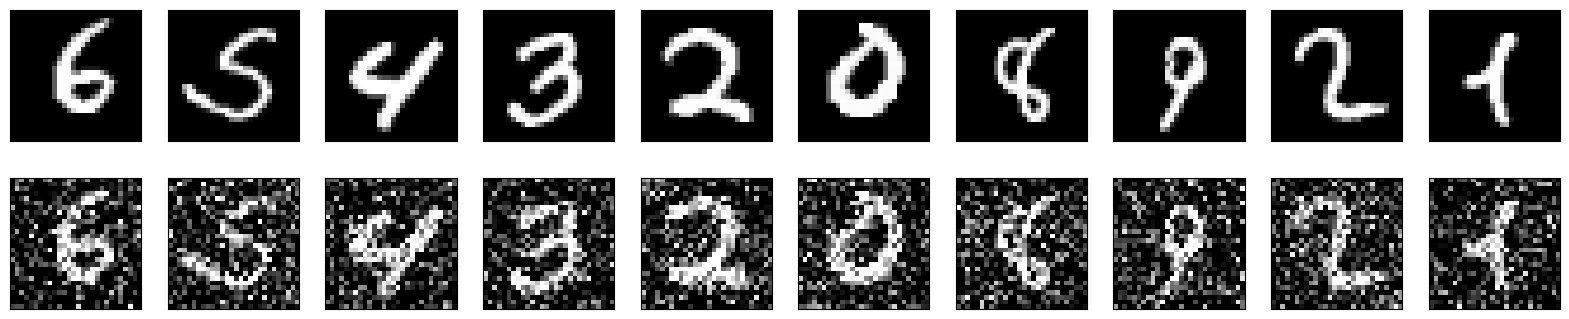

In [2]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [3]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

I0000 00:00:1761461432.094136   56861 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8801 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50


2025-10-26 07:50:33.924796: I external/local_xla/xla/service/service.cc:163] XLA service 0x77bb4c00cfd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-26 07:50:33.924806: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-10-26 07:50:33.946137: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-26 07:50:34.103743: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
2025-10-26 07:50:34.244324: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[128,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_cal

 57/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5787

I0000 00:00:1761461435.168943   56941 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


458/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2481

2025-10-26 07:50:36.591573: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[96,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-26 07:50:36.610265: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[96,32,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,32,14,14]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cud

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2454

2025-10-26 07:50:37.611110: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[128,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-26 07:50:37.630685: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[128,32,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,14,14]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="_

469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1299 - val_loss: 0.0727
Epoch 2/50
  1/469 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0747

2025-10-26 07:50:37.904252: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-26 07:50:37.919124: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,32,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,14,14]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cud

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0712 - val_loss: 0.0692
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0691 - val_loss: 0.0680
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0681 - val_loss: 0.0671
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0673 - val_loss: 0.0667
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0668 - val_loss: 0.0661
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0663 - val_loss: 0.0656
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0660 - val_loss: 0.0653
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0656 - val_loss: 0.0652
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0654 - val_loss: 0.0649
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0652 - val_loss: 0.0648
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0650 - val_loss: 0.0644
Epoch 13/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0

 73/313 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step  

2025-10-26 07:52:05.723272: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,28,28]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-26 07:52:05.741652: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,14,14]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cud

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


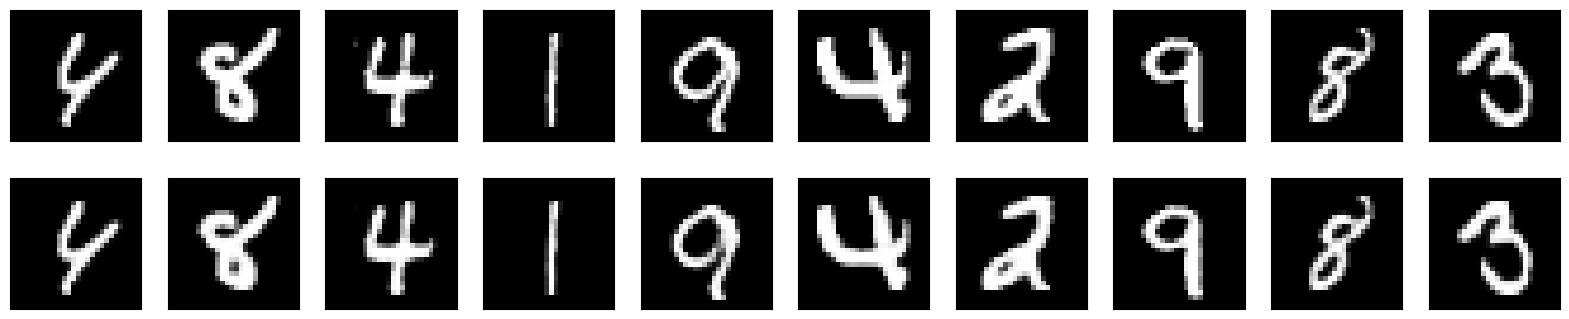

In [5]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [6]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1020 - val_loss: 0.0943
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0937 - val_loss: 0.0921
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0921 - val_loss: 0.0909
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0910 - val_loss: 0.0901
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0902 - val_loss: 0.0893
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0896 - val_loss: 0.0889
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0891 - val_loss: 0.0884
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0887 - val_loss: 0.0880
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0883 - val_loss: 0.0876
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0879 - val_loss: 0.0873
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0877 - val_loss: 0.0870
Epoch 12/100
469/469 ━━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step


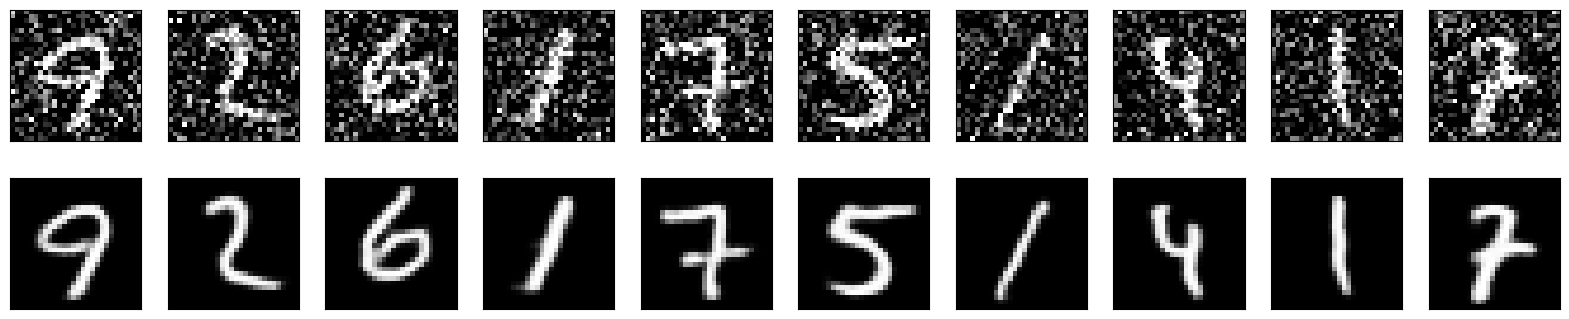

In [7]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)